In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils import data
import torchvision
import sys
from copy import deepcopy
#from visdom import Visdom

from dataset import DeepmoonDataset

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
Tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor


# Visualization
import time
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#More libraries
import random


print("Using GPU:" + str(use_cuda))

Using GPU:False


Fix random seed

In [3]:
seed = 128

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed_all(seed)


Parameters

In [4]:
batch_size = 128
latent_size = 64
n_features = 32
lr = 0.0002
betas = (0.5, 0.999)
n_epochs = 10000
n_critic = 5
n_print = 137
gamma = 0.8

Paramaters for the constraints

In [5]:
start_max = 2
end_max = 2
start_min = 1
end_min = 1
lmbda = 10


Load data and split into training and validation sets

In [6]:
json_path = '../data/2016.json'
validation_split = 0.2

dataset = DeepmoonDataset(json_path)

split_len = [round((1-validation_split) * len(dataset)), round(validation_split * len(dataset))]
split = {x: y for x, y in zip(['train', 'val'], data.random_split(dataset, lengths=split_len))}

loader = {x: data.DataLoader(split[x], batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


### Create the nn

Let's define a convolutional and a deep convolutional units

In [7]:
class DCUnit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DCUnit, self).__init__()
        self.dcunit = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.dcunit(x)


In [8]:
class CUnit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(CUnit, self).__init__()
        self.cunit = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.cunit(x)


Generator Network

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_size, n_features):
        super(Generator, self).__init__()
        self.dcnn = nn.Sequential(
            DCUnit(latent_size, 4 * n_features, 4, 1, 0),
            DCUnit(4 * n_features, 2 * n_features, 4, 2, 1),
            DCUnit(2 * n_features, n_features, 4, 2, 1),

            nn.ConvTranspose2d(n_features, 3, 4, 2, 1),
            nn.Sigmoid(),
            nn.Upsample(size=(18, 11))
        )

    def forward(self, x):
        return self.dcnn(x)



Discriminator Network

In [10]:
class Discriminator(nn.Module):
    def __init__(self, n_features):
        super(Discriminator, self).__init__()

        self.cnn = nn.Sequential(
            nn.Upsample(size=(32, 32)),

            CUnit(3, n_features, 4, 2, 1),
            CUnit(n_features, 2 * n_features, 4, 2, 1),
            CUnit(2 * n_features, 4 * n_features, 4, 2, 1),

            nn.Conv2d(4 * n_features, 1, 4, 1, 0),
        )

        self.fc = nn.Sequential(nn.Linear(1 + 1, 32),nn.Linear(32, 1))

    def forward(self, x):
        img, penalty = x
        out_img = self.cnn(img).view(img.size(0), -1)
        inputs = torch.cat([out_img, penalty], dim=1)
        return self.fc(inputs)


In [11]:
netG = Generator(latent_size, n_features)
netD = Discriminator(n_features)
netG.to(device)
netD.to(device)

Discriminator(
  (cnn): Sequential(
    (0): Upsample(size=(32, 32), mode=nearest)
    (1): CUnit(
      (cunit): Sequential(
        (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace)
      )
    )
    (2): CUnit(
      (cunit): Sequential(
        (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace)
      )
    )
    (3): CUnit(
      (cunit): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace)
      )
    )
    (4): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1))

In [12]:
optimizerD = torch.optim.Adam(netD.parameters(), lr, betas)
optimizerG = torch.optim.Adam(netG.parameters(), lr, betas)

Im not sure of what this function does

In [13]:
class RoundNoGradient(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x.round()
    @staticmethod
    def backward(ctx, g):
        return g


Define penalties

In [14]:
def channel_penalty(x_fake, start_max, end_max, start_min, end_min):
    count = torch.sum(RoundNoGradient.apply(x_fake), (2, 3))

    count_start = count[:, 0]
    count_end = count[:, 2]

    g_start_max = torch.relu(count_start - start_max) ** 2
    g_end_max = torch.relu(count_end - end_max) ** 2

    g_start_min = torch.relu(-count_start + start_min) ** 2
    g_end_min = torch.relu(-count_end + end_min) ** 2
    return (g_start_max + g_end_max + g_start_min + g_end_min).view(x_fake.size(0), -1)

def duplicate_penalty(x_fake):
    count = torch.sum(RoundNoGradient.apply(x_fake), 1, keepdim=True)
    g = torch.sum(torch.relu(count - 1) ** 2, (2, 3))
    return g.view(x_fake.size(0), -1)

def gradient_penalty(D, x_real, x_fake,penalty):
    batch_size = x_real.size(0)

    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    x_merged = (epsilon * x_real + (1 - epsilon) * x_fake).requires_grad_(True)
    out_merged = D((x_merged, penalty))

    grad, = torch.autograd.grad(
        outputs=out_merged,
        inputs=x_merged,
        grad_outputs=Tensor(batch_size, 1).fill_(1),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )

    return ((grad.view(batch_size, -1).norm(2, dim=1) - 1)**2).mean()

def avg_start_end(x_fake, start_max, end_max, start_min, end_min):
    count = torch.sum(x_fake.round(), (2, 3))

    count_start = count[:, 0]
    count_end = count[:, 2]

    count_start.apply_(lambda x: 1 if start_max >= x >= start_min else 0)
    count_end.apply_(lambda x: 1 if end_max >= x >= end_min else 0)

    valid_solutions = Tensor([1 if s == 1 and e == 1 else 0
                              for s, e in zip(count_start, count_end)])

    return count_start.mean(), count_end.mean(), valid_solutions.mean()


In [15]:
epoch=1000
4 if epoch > 100 else torch.zeros([10, 1], device=device)


4

In [16]:
def train_generator(optim,real_data,epoch):
    netG.zero_grad()

    # Creamos una imagen falsa
    x_fake = netG(torch.randn(real_data.size(0), latent_size, 1, 1, device=device))

     #Calculamos los penalties a esta imagen
    penalty = 0.1 * channel_penalty(x_fake, start_max, end_max, start_min, end_min) + 0.1 * duplicate_penalty(x_fake) if epoch > 100 else torch.zeros([real_data.size(0), 1], device=device)

            # Calculamos el error del discriminador anadiento tanto la imagen falsa como el penalty
    out_fake = netD((x_fake, penalty))

    lossG = -torch.mean(out_fake) \

    lossG.backward()
    optim.step()
    
    return lossG

for i, data in enumerate(loader['train']):
    aa = data['moves'].type(Tensor)
    a=train_generator(optimizerG,aa,0)
    print(a)
    break
    

/Users/cmougan/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


tensor(-0.1970, grad_fn=<NegBackward>)


In [17]:
def train_discriminator(optim,real_data):
   
    netD.zero_grad()
    # Creamos un set de números aleatorios y producimos una imagen con ellos
    z = torch.randn(real_data.size(0), latent_size, 1, 1, device=device)
    x_fake = netG(z)
    
    # Computamos los penalty (definidos en las funciones anteriores)
    penalty = 0.1 * channel_penalty(x_fake, start_max, end_max, start_min, end_min) + 0.1 * duplicate_penalty(x_fake) if epoch > 100 else torch.zeros([N, 1], device=device)

    
    #Hacemos la predicción de la imagen con el discriminador para el real y el fake
    out_real = netD((real_data, torch.zeros([real_data.size(0), 1], device=device)))
    out_fake = netD((x_fake, penalty))

    #Anadimos la loss function interpolando entre la media del error de la real y de fake
    # introducimos el valor del penalty
    error_d = torch.mean(out_fake) - torch.mean(out_real) + lmbda * gradient_penalty(netD, real_data.data, x_fake.data,penalty) 
    #Hacemos el backward propagation y damos un step en la dirección del gradiente 
        # del discriminador
    error_d.backward(retain_graph=True)
    optim.step()

    
    return error_d
for i, data in enumerate(loader['train']):
    aa = data['moves'].type(Tensor)
    a=train_discriminator(optimizerD,aa)
    print(a)
    break
    



tensor(684.9302, grad_fn=<AddBackward0>)


Start trainning

NameError: name 'b' is not defined

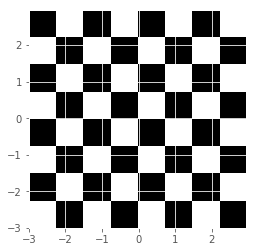

In [18]:
import matplotlib.pyplot as plt
import numpy as np


def func3(x, y):
    return (1 - x / 2 + x**5 + y**3) * np.exp(-(x**2 + y**2))


# make these smaller to increase the resolution
dx, dy = 0.05, 0.05

x = np.arange(-3.0, 3.0, dx)
y = np.arange(-3.0, 3.0, dy)
X, Y = np.meshgrid(x, y)

# when layering multiple images, the images need to have the same
# extent.  This does not mean they need to have the same shape, but
# they both need to render to the same coordinate system determined by
# xmin, xmax, ymin, ymax.  Note if you use different interpolations
# for the images their apparent extent could be different due to
# interpolation edge effects

extent = np.min(x), np.max(x), np.min(y), np.max(y)
fig = plt.figure(frameon=False)

Z1 = np.add.outer(range(8), range(8)) % 2  # chessboard
im1 = plt.imshow(Z1, cmap=plt.cm.gray, interpolation='nearest',
                 extent=extent)

Z2 = func3(X, Y)

im2 = plt.imshow(b, cmap='mako', alpha=1, interpolation='bilinear',
                 extent=extent)

plt.show()

In [19]:
aa[2][0][17][9]=10

In [20]:
aa[2][0]

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  

In [21]:
aa[1][1][3][4]

tensor(0.)

In [22]:
jjj

NameError: name 'jjj' is not defined

In [23]:
a[41][2]

RuntimeError: dimension specified as 0 but tensor has no dimensions

In [33]:
i=41
a = aa
a[i][2][17][1]=1
#a[i][][17][9]= 1
b = 3*(a[i][0])+10*a[i][1]+15*a[i][2]



In [30]:
b.size()

torch.Size([18, 11])

In [58]:
bb = torch.zeros_like(b)

In [59]:
bb[0][6] = 3

bb[1][8] = 10
bb[4][8] = 10
bb[6][10] = 10
bb[8][9] = 10
bb[10][9] = 10
bb[12][7] = 10

bb[13][10] = 15
bb[16][7] = 15


In [60]:
bb

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 15.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  

In [61]:
import seaborn as sns
sns.set_style("ticks")
plt.style.use('ggplot')

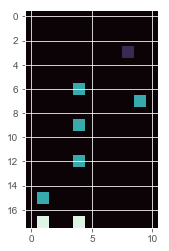

In [62]:
plt.imshow(b, cmap='mako')
plt.show()

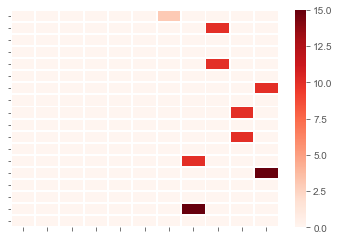

In [64]:
ax = sns.heatmap(bb, linewidth=0.9, cmap="Reds")
ax.set(xticklabels=[''])
ax.set(yticklabels=[])
plt.savefig('encodingmoond.png')
plt.show()

In [ ]:
fixed_noise = torch.randn(128, latent_size, 1, 1, device=device)

history = {'lossD': [], 'lossG': [], 'avgStart': [], 'avgEnd': [],
           'valid': [], 'validHist': [], 'imgs': [],'epoch': []}

for epoch in range(n_epochs):

    for i, data in enumerate(loader['train']):

        x_real = data['moves'].type(Tensor)
        break
       

       
        N = x_real.size(0)
        
        lossD = train_discriminator(optimizerD,x_real)

        # En un número ciclico de veces entrenamos el Generador
        if i % n_critic == 0:

            lossG = train_generator(optimizerG,x_real,epoch)

        # Print training stats
        if i % n_print == 0:
            
            plt.figure()
            plt.plot(history['lossD'],'r',label='loss_Discriminator')
            plt.plot(history['lossG'],'k',label='loss_Generator')
            plt.plot(history['avgStart'],'*b',label='Average Start')
            plt.plot(history['avgEnd'],'*y',label='Average End')
            
            plt.legend(loc=(1,0.7))
            
            try:
                plt.title('Generator and Discriminator loss evolution in epoch: {}'.format(history['epoch'][-1]))
            except:
                plt.title('Generator and Discriminator loss evolution in epoch: 0')
            
            display.clear_output(wait=False)
            display.display(plt.gcf())
            time.sleep(1)
            print(
                "[Epoch {:5}/{:5}] [Batch {:3}/{:3}] [D loss: {:2.6f}] [G loss: {:2.6f}]".format(
                    epoch, n_epochs, i, len(loader['train']), lossD.item(), lossG.item()
                )
            )


    # Save losses in history and update plot
    with torch.no_grad():
        history['imgs'] += [netG(fixed_noise).detach().cpu()]
        avgStart, avgEnd, valid = avg_start_end(history['imgs'][-1].detach(), start_max, end_max, start_min, end_min)

    history['lossD'] += [lossD.item()]
    history['lossG'] += [lossG.item()]
    history['avgStart'] += [avgStart.item()]
    history['avgEnd'] += [avgEnd.item()]
    history['valid'] += [valid.item()]
    history['validHist'] += [sum(history['valid'][-20:]) / len(history['valid'][-20:])]
    history['epoch'] += [epoch]
